In [1]:
import boto3
import sagemaker
import time
import cv2
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO

In [2]:
print(boto3.__version__)
print(sagemaker.__version__)

1.17.39
2.32.0


In [49]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
print(bucket)
print(role)

sagemaker-us-east-2-805291263703
arn:aws:iam::805291263703:role/service-role/AmazonSageMaker-ExecutionRole-20200826T145400


In [4]:
prefix = 'pytorch-text-recognize'

In [ ]:
model_path = sess.upload_data('model.tar.gz', bucket=bucket, key_prefix=prefix + '/aster')
print(model_path)

# Create model, endpoint configuration and endpoint

In [5]:
sm = boto3.client('sagemaker')

In [87]:
model_name = prefix + '-' + time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
print(model_name)

pytorch-text-recognize-2021-04-02-07-03-38


In [88]:
response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    Containers = [
        {
            'Image': '763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-inference:1.6-cpu-py3',
            'ModelDataUrl': 's3://{}/{}/aster/model.tar.gz'.format(bucket, prefix),
            'Mode': 'SingleModel',
            'Environment': {
                'SAGEMAKER_PROGRAM': 'inference.py',
                'SAGEMAKER_SUBMIT_DIRECTORY': '/opt/ml/model/code',
                'SAGEMAKER_CONTAINER_LOG_LEVEL': '20',
                'SAGEMAKER_REGION': 'us-east-2',
                'MMS_DEFAULT_RESPONSE_TIMEOUT': '500'
            }
        }
    ]
)
print(response)

{'ModelArn': 'arn:aws:sagemaker:us-east-2:805291263703:model/pytorch-text-recognize-2021-04-02-07-03-38', 'ResponseMetadata': {'RequestId': '0173c23f-0264-4ca3-907f-93c9398f389d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '0173c23f-0264-4ca3-907f-93c9398f389d', 'content-type': 'application/x-amz-json-1.1', 'content-length': '104', 'date': 'Fri, 02 Apr 2021 07:03:39 GMT'}, 'RetryAttempts': 0}}


In [89]:
epc_name = prefix + '-epc-' + time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
print(epc_name)

pytorch-text-recognize-epc-2021-04-02-07-03-42


In [90]:
response = sm.create_endpoint_config(
    EndpointConfigName = epc_name,
    ProductionVariants = [
        {
            'ModelName': model_name,
            'VariantName': 'variant-1',
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.large',
            'InitialVariantWeight': 1
        }
    ]
)
print(response)

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-2:805291263703:endpoint-config/pytorch-text-recognize-epc-2021-04-02-07-03-42', 'ResponseMetadata': {'RequestId': '5a175628-8a1b-42fb-aa7d-0b4afc5b6639', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '5a175628-8a1b-42fb-aa7d-0b4afc5b6639', 'content-type': 'application/x-amz-json-1.1', 'content-length': '127', 'date': 'Fri, 02 Apr 2021 07:03:42 GMT'}, 'RetryAttempts': 0}}


In [91]:
ep_name = prefix + '-ep-' + time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
print(ep_name)

pytorch-text-recognize-ep-2021-04-02-07-03-43


In [92]:
response = sm.create_endpoint(
    EndpointName = ep_name,
    EndpointConfigName = epc_name
)
print(response)

{'EndpointArn': 'arn:aws:sagemaker:us-east-2:805291263703:endpoint/pytorch-text-recognize-ep-2021-04-02-07-03-43', 'ResponseMetadata': {'RequestId': '716e8c5a-8b61-4ac6-93af-95ad7a5aabe5', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '716e8c5a-8b61-4ac6-93af-95ad7a5aabe5', 'content-type': 'application/x-amz-json-1.1', 'content-length': '113', 'date': 'Fri, 02 Apr 2021 07:03:43 GMT'}, 'RetryAttempts': 0}}


In [93]:
sm.describe_endpoint(EndpointName=ep_name)

{'EndpointName': 'pytorch-text-recognize-ep-2021-04-02-07-03-43',
 'EndpointArn': 'arn:aws:sagemaker:us-east-2:805291263703:endpoint/pytorch-text-recognize-ep-2021-04-02-07-03-43',
 'EndpointConfigName': 'pytorch-text-recognize-epc-2021-04-02-07-03-42',
 'EndpointStatus': 'Creating',
 'CreationTime': datetime.datetime(2021, 4, 2, 7, 3, 44, 824000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2021, 4, 2, 7, 3, 44, 824000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'e5242395-80ed-40bb-ba15-8ad56eebbe1b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e5242395-80ed-40bb-ba15-8ad56eebbe1b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '342',
   'date': 'Fri, 02 Apr 2021 07:03:44 GMT'},
  'RetryAttempts': 0}}

In [94]:
waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=ep_name)

# Inference

In [14]:
smrt = boto3.client('sagemaker-runtime')

In [123]:
test_dir = './test'

In [124]:
test_imgs = os.listdir(test_dir)

Recognition text:  "clearance"


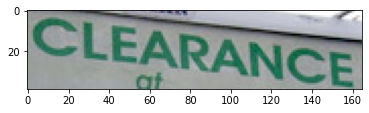

Recognition text:  "guerledan"


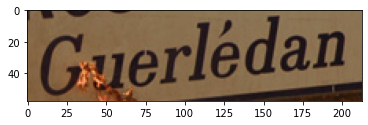

Recognition text:  "eragon"


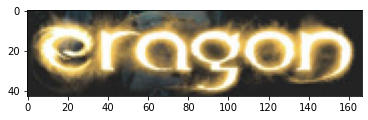

Recognition text:  "available"


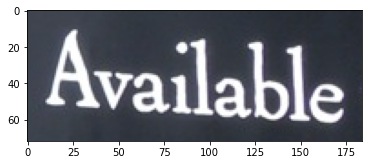

Recognition text:  "roaches"


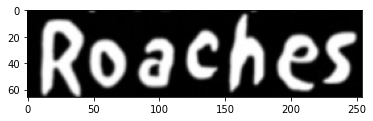

Recognition text:  "cirlsberg"


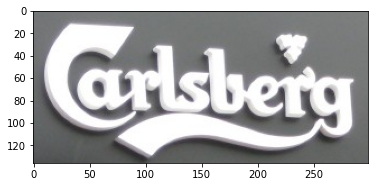

Recognition text:  "shakeshack"


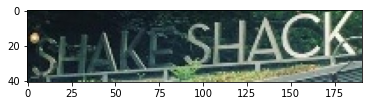

Recognition text:  "advertise"


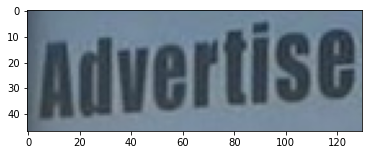

Recognition text:  "lugn"


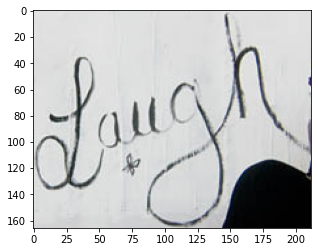

In [126]:
for i in range(len(test_imgs)):
    im = cv2.imread(os.path.join(test_dir, test_imgs[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    tensor_x = im
    buffer = BytesIO()
    np.save(buffer, tensor_x)

    response = smrt.invoke_endpoint(
        EndpointName=ep_name,
        Body=buffer.getvalue(),
        ContentType='application/x-npy'
    )
    print('Recognition text: ', response['Body'].read().decode('utf-8'))
    plt.imshow(im)
    plt.show()

# Delete model, endpoint configuration and endpoint

In [127]:
sm.delete_endpoint(EndpointName=ep_name)

{'ResponseMetadata': {'RequestId': '560a4877-13e4-40ed-a585-bf67723de4b5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '560a4877-13e4-40ed-a585-bf67723de4b5',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 02 Apr 2021 07:41:14 GMT'},
  'RetryAttempts': 0}}

In [128]:
sm.delete_endpoint_config(EndpointConfigName=epc_name)

{'ResponseMetadata': {'RequestId': '78662e29-d130-43bd-b765-c3ddfadff099',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '78662e29-d130-43bd-b765-c3ddfadff099',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 02 Apr 2021 07:41:15 GMT'},
  'RetryAttempts': 0}}

In [129]:
sm.delete_model(ModelName=model_name)

{'ResponseMetadata': {'RequestId': '5862c956-ef25-444a-b99e-d6dca6013c2d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5862c956-ef25-444a-b99e-d6dca6013c2d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 02 Apr 2021 07:41:17 GMT'},
  'RetryAttempts': 0}}